### Fractional Differencing

Start Date: 7/1/2023

In this notebook, we go through the foundations of fractional differencing. The material here is coming from the book **Advanced in Financial Machine Learning** by Marcos Lopez de Prado, Chapter 5. 

Traditionally, when we are doing time series modeling, we want to model stationary series. We usually want to deal with *weakly* stationary series in which we can say that the mean and variance is the same over time. We know that financial time series are not stationary and we usually do some type of differencing of the series until it is. However, in doing the traditional transformations, there is a lot of memory that you lose in this process. The goal is to find an optimal level of differencing in the series such that we achieve stationary (as shown by some statistical tests) but we preserve memory as much as possible (so that your model can learn patterns in the time series). 

We will: 
* Lay the foundations for fractional differencing and implement the logic 
* Test it out on a sample time series of prices from yahoo finance 
* Demonstrate the "optimality point" in differencing

The hope is that as we go through this, the fractionalized series can be inputs to a prediction model in the future. The code here will be used in other modules. 

##### Implementing fixed window fractional differencing

Fixed Window Fractional Differencing is where you cut off your fractional weights up to some tolerance and apply that to a rolling series. 

In [1]:
import pandas as pd 
import yfinance as yf 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def get_frac_weights(d: float, n: int) -> np.array: 

    weights = [] 

    for i in range(n): 
        if i == 0: 
            weights.append(1)
        else: 
            w = -weights[i-1]*(d - i + 1)/i
            weights.append(w)

    return np.array(weights)

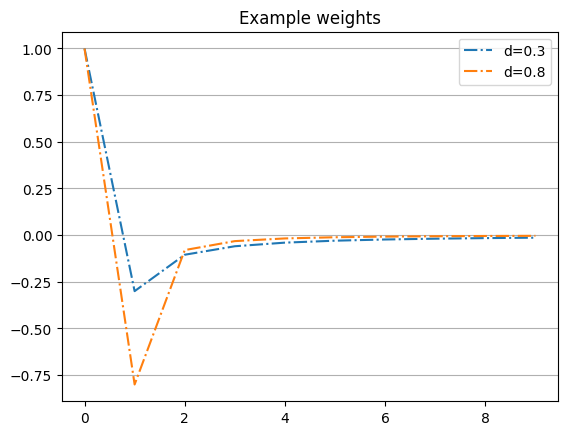

In [23]:
low_d = 0.3
high_d = 0.8

weights_example_low_d = get_frac_weights(d = low_d, n = 10)
weights_example_high_d = get_frac_weights(d = high_d, n = 10)
plt.plot(weights_example_low_d, linestyle = 'dashdot', label = f'd={low_d}')
plt.plot(weights_example_high_d, linestyle = 'dashdot', label = f'd={high_d}')
plt.legend()
plt.title("Example weights")
plt.grid(axis = 'y')
plt.show()

A couple of things that we can notice: 
* The initial weight is 1 --> it will always be that 
* The subsequent values are all negative and tend towards zero. You are including information about the long past into this
* As the d value changes between 0 and 1, we get a higher weight on the second observation. You would expect that as you go to 1, you get regular differencing and all the values are zero. 

In [25]:
data = yf.download("BTC-USD", progress=False)
close_price = data['Adj Close']
log_price = close_price.apply(np.log)

In [49]:
# We want to find the index at which the tolerance hits a certain level
weights = get_frac_weights(d = 0.3, n = log_price.shape[0])
abs_weights = np.abs(weights)

In [50]:
tol = 0.001
# We get the length of the series at which we weight is above this amount
l = np.where(abs_weights >= tol)[0].max() + 1
w = weights[:l]


In [52]:
frac_diff_series = log_price.rolling(l).apply(lambda x: (x * w[::-1]).sum())

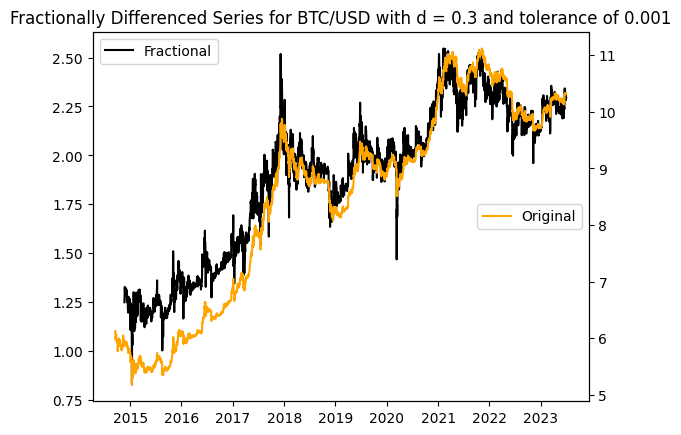

In [75]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(frac_diff_series, color = 'black', label = 'Fractional')
ax2.plot(log_price, color = 'orange', label = 'Original')
ax.legend()
ax2.legend(loc = 5)
plt.title("Fractionally Differenced Series for BTC/USD with d = 0.3 and tolerance of 0.001")
plt.show()

#### Stationary Testing of Fractional Series

We want to understand the stationary of the time series we are dealing with. To test stationarity, we can use the Augmented Dickey-Fuller test. This is implemented in statsmodels and we can use it here. 

In [88]:
class FFDTransform: 

    def __init__(self, d: float, tol: float) -> None:
        self.d = d 
        self.tol = tol 
        self.is_fit = False

    @classmethod 
    def get_frac_weights(d: float, n: int) -> np.array: 

        weights = [] 

        for i in range(n): 
            if i == 0: 
                weights.append(1)
            else: 
                w = -weights[i-1]*(d - i + 1)/i
                weights.append(w)

        return np.array(weights)
    
    def get_l_star_value(self) -> int:

        abs_weights = np.abs(self.weights) 
        l_star = np.where(abs_weights >= tol)[0].max() + 1
        return l_star
    
    def fit(self, series: pd.Series): 

        self.weights = get_frac_weights(d = self.d, n = series.shape[0])
        self.l_star = self.get_l_star_value()
        self.is_fit = True

    def fit_transform(self, series: pd.Series) -> pd.Series: 
        self.fit(series)
        return self.transform(series)

    def transform(self, series: pd.Series) -> pd.Series: 
        assert self.is_fit, "The FFD has to be fit. Please call the fit method"
        
        if self.l_star > series.shape[0]: 
            l = series.shape[0]
        else: 
            l = self.l_star

        w = self.weights[:l]
        return series.rolling(l).apply(lambda x: (x*w[::-1]).sum())

In [93]:
# Creating an initial FFD transformation here

ffd_transform = FFDTransform(d = 0.3, tol = 0.001)
ffd_transform.fit(series = log_price)
ffd_series = ffd_transform.transform(series = log_price)

<Axes: xlabel='Date'>

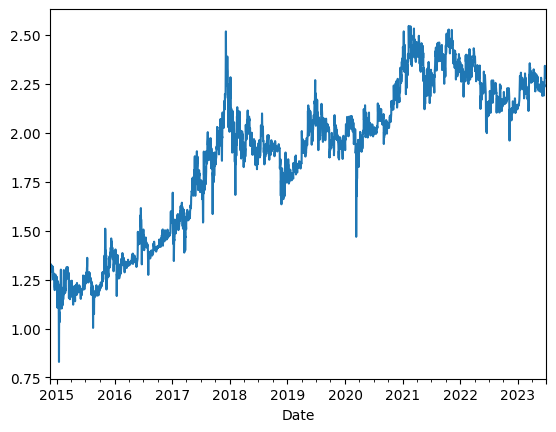

In [94]:
ffd_series.dropna().plot()

#### Conclusions

We showed here how you can do fractional differencing on your time series and what different differencing orders can do to your time series. We also have this class called `FFDTransform` which works almost like the `StandardScaler` class in sklearn to take in your time series and fit with some transformations. We can use this class later for feature transformations later. 

Some follow up items to this: 
* Show how with varying levels of d, we get different p-values for stationarity 
* Try to predict the differenced series using lagged values of itself. Do we get better prediction capacity with something like an LSTM model? 
* What does differencing look like with d > 1 and less than 2? 
* Can we use this as a feature in other machine learning models? 

